In [289]:
%pip install gensim nltk

## 1. Reading and cleaning the file

In [290]:
import codecs, re
import random
random.seed(123)

# Read the file...:
f = codecs.open("pg3300.txt", "r", "utf-8")
string_data = f.read()

#... and separate into paragraphs as proposed on Piazza:
corpus = []
curr_para = ""
f = codecs.open("pg3300.txt", "r", "utf-8")
for line in string_data.split("\r\n"):
    # If the line is just whitespace (we don't care about newlines and punctuation here):
    if all([c == " " for c in line]):
        # Add the current paragraph to the corpus (if it is not empty), and reset
        if len(curr_para) > 0:
            corpus.append(curr_para)
        curr_para = ""
    # Else, we just append the line to the paragraph
    else:
        curr_para += line + "\n"
len(corpus)

2251

In [291]:
# Filter unwanted paragraphs (footer, header)
corpus = list(filter(lambda x: "gutenberg" not in x.lower(), corpus))

# Clean the text a bit for better representation
corpus = [re.sub(' +', ' ', para).strip() for para in corpus]

# Now see the new corpus size, and example document:
print(len(corpus))
corpus[100]

2207


'In the English mint, a pound weight of gold is coined into forty-four\n guineas and a half, which at one-and-twenty shillings the guinea, is equal\n to forty-six pounds fourteen shillings and sixpence. An ounce of such gold\n coin, therefore, is worth £ 3:17:10½ in silver. In England, no duty or\n seignorage is paid upon the coinage, and he who carries a pound weight or\n an ounce weight of standard gold bullion to the mint, gets back a pound\n weight or an ounce weight of gold in coin, without any deduction. Three\n pounds seventeen shillings and tenpence halfpenny an ounce, therefore, is\n said to be the mint price of gold in England, or the quantity of gold coin\n which the mint gives in return for standard gold bullion.'

As a result of the cleaning, we went from 2251 documents to 2207 documents total.

Now let's preprocess the text for use in a retrieval model:

In [292]:
from nltk.stem.porter import PorterStemmer
import string

# This is used for preprocessing of both the corpus and queries
def preprocessing(text):
    # Initiate stemmer
    stemmer = PorterStemmer()

    # Define unwanted characters (punctuation)
    bad_chars = string.punctuation+"\n\r\t"

    # Clean, tokenize and stem text
    new_text = text = text.lower() # all lower case
    new_text = "".join(list(filter(lambda x: x not in bad_chars, new_text))) # remove unwanted chars
    new_text = new_text.split(" ") # tokenize (split into words)
    new_text = list(filter(lambda c: len(c) > 0, new_text)) # remove empty strings
    new_text = [stemmer.stem(word) for word in new_text] # perform stemming
    return new_text

In [293]:
# Perform preprocessing on the corpus (we just call it 'collection' now)
collection = [preprocessing(text) for text in corpus]

Let's look at the word frequencies:

In [294]:
from nltk import FreqDist
freqDist = FreqDist(" ".join([" ".join(para) for para in collection]).split(" "))

In [295]:
freqDist['tax']

881

The word 'tax' (or variations of the word) is mentioned 881 times in the collection.

We can plot the top words like this:

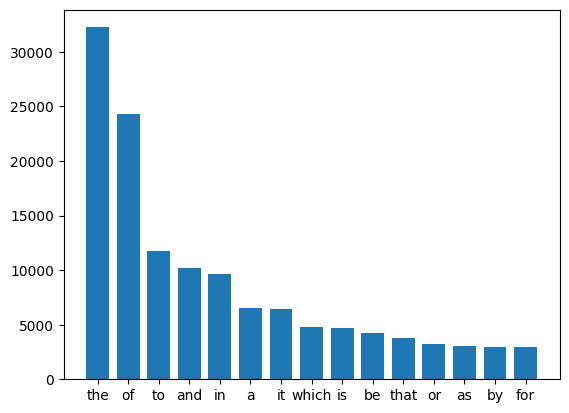

In [296]:
import matplotlib.pyplot as plt
import numpy as np

sorted_freq_dist = dict(sorted(freqDist.items(), key=lambda x:x[1], reverse=True))

x = np.linspace(0,15,15)
x_labels = list(sorted_freq_dist.keys())[:15]
y = list(sorted_freq_dist.values())[:15]

plt.xticks(x, x_labels)

plt.bar(x,y);

The word 'the' is mentioned A LOT, and it is thus pretty useless for retrieval. Next, we will remove such useless words.

## 2. Dictionary building
We create a dictionary:

In [297]:
import gensim
dictionary = gensim.corpora.Dictionary(collection)

Then we filter out common words from the dictionary:

In [298]:
f = codecs.open("common-english-words.txt", "r", "utf-8")
common_words = f.read().split(",") # get a list of common words

# Filter out all words that are not actually in the dictionary
common_words = list(filter(lambda x: x in dictionary.values(), common_words))

# Generate tokens and remove all common words from the dictionary
tokens_ids = [dictionary.token2id[word] for word in common_words]
dictionary.filter_tokens(tokens_ids)

Now we can generate a bag-of-words model from out collection and the reduced dictionary:

In [299]:
# Generate a bag-of-words model from the collection
bow_collection = [dictionary.doc2bow(doc) for doc in collection]

## 3. Retrieval Models
Initialize TF-IDF model with the BoW-collection and LSI model with the generated TF-IDF collection

In [300]:
tfidf_model = gensim.models.TfidfModel(bow_collection)
tfidf_corpus = tfidf_model[bow_collection]
sim_tfidf = gensim.similarities.MatrixSimilarity(tfidf_corpus, num_features=len(dictionary))

In [301]:
lsi_model = gensim.models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=100)
lsi_corpus = lsi_model[tfidf_corpus]
sim_lsi = gensim.similarities.MatrixSimilarity(lsi_corpus, num_features=len(dictionary))

Let's look at the topics gathered by the LSI-model:

In [302]:
lsi_model.show_topics(3)

[(0,
  '0.146*"labour" + 0.137*"price" + 0.128*"employ" + 0.127*"produc" + 0.122*"capit" + 0.122*"countri" + 0.120*"trade" + 0.119*"hi" + 0.115*"tax" + 0.113*"land"'),
 (1,
  '-0.250*"labour" + 0.210*"silver" + -0.204*"rent" + 0.196*"gold" + -0.194*"land" + -0.189*"stock" + -0.184*"employ" + -0.183*"profit" + -0.175*"capit" + 0.159*"coin"'),
 (2,
  '0.346*"price" + 0.238*"silver" + 0.208*"quantiti" + -0.207*"trade" + 0.169*"labour" + -0.166*"coloni" + 0.160*"gold" + 0.159*"valu" + 0.136*"corn" + 0.133*"coin"')]

So, for, e.g., the first topic, we see that the words "labour" and "price", etc. often occurs. The word "land" occurs a bit less frequently, etc.

# 4. Querying

In [303]:
query = "What is the function of money?"
#query = "How taxes influence Economics?"

# Perfrom query preprocessing
query = preprocessing(query)
bow_query = dictionary.doc2bow(query) # turn into bag-of-words
tfidf_query = tfidf_model[bow_query] # turn into (ID, TF-IDF-weight)-pairs
lsi_query = lsi_model[tfidf_query] # turn into LSI-query

print("Preprocessed query (id : word : weight):")
for _id, val in tfidf_query:
	print(f"{_id:<4} : {dictionary[_id]:<10} : {val:.4f}")

Preprocessed query (id : word : weight):
47   : money      : 0.3145
1195 : function   : 0.9493


Here we can see the query is turned into two words "money" and "function", with TF_IDF-weight ~$0.31$ and ~$0.95$, respectively.

Now, let's rank the documents using the TF-IDF model:

In [304]:
# Print three best ranked documents (IF-IDF)
doc2sim = enumerate(sim_tfidf[tfidf_query])
rankings = sorted(doc2sim, key=lambda kv: -kv[1])[:3]
for _id, rank in rankings:
	print(f"[paragraph {_id}] (Score: {rank*100:.5f})")
	doc = corpus[_id]
	print("\n".join(doc.split("\n")[:5]), end="\n\n") # Print 5 lines

[paragraph 681] (Score: 43.89099)
The general stock of any country or society is the same with that of all
 its inhabitants or members; and, therefore, naturally divides itself into
 the same three portions, each of which has a distinct function or office.

[paragraph 992] (Score: 28.47361)
That wealth consists in money, or in gold and silver, is a popular notion
 which naturally arises from the double function of money, as the
 instrument of commerce, and as the measure of value. In consequence of its
 being the instrument of commerce, when we have money we can more readily
 obtain whatever else we have occasion for, than by means of any other

[paragraph 816] (Score: 26.85705)
Whatever part of his stock a man employs as a capital, he always expects
 it to be replaced to him with a profit. He employs it, therefore, in
 maintaining productive hands only; and after having served in the function
 of a capital to him, it constitutes a revenue to them. Whenever he employs
 any part of it i

We see docs 681, 992 and 816 are the top documents. They all contain the words "function" and "money", so this makes sense.



Now we can rank the LSI-topics using the TF-IDF query weights:

In [305]:
# Print three top topics
doc2sim = enumerate(sim_lsi[lsi_query])
rankings = sorted(lsi_query, key=lambda kv: -abs(kv[1]))[:3]
for _id, rank in rankings:
	print(f"[topic {_id}] (Score: {abs(rank)*100:.5f})")
	print(lsi_model.print_topic(_id), end="\n\n")

[topic 62] (Score: 7.10585)
0.187*"money" + -0.147*"proport" + 0.136*"caus" + 0.125*"class" + 0.122*"pound" + 0.108*"british" + -0.107*"revenu" + -0.107*"town" + 0.107*"stock" + -0.099*"improv"

[topic 4] (Score: 6.87653)
0.262*"bank" + -0.241*"price" + 0.230*"circul" + 0.218*"capit" + 0.192*"gold" + 0.184*"money" + -0.171*"corn" + -0.144*"tax" + 0.142*"coin" + -0.137*"import"

[topic 15] (Score: 6.01430)
-0.283*"coloni" + -0.278*"circul" + 0.208*"increas" + 0.183*"cent" + 0.180*"per" + 0.175*"coin" + -0.163*"money" + -0.147*"chapter" + -0.143*"paper" + -0.138*"hi"



For topic 62, "money", "class" and "stock" is often discussed, but "proportion*" and "revenue" is not very often discussed.

Now we rank using the LSI model:

In [306]:
# Print three best ranked documents (LSI)
doc2sim = enumerate(sim_lsi[lsi_query])
rankings = sorted(doc2sim, key=lambda kv: -abs(kv[1]))[:3]
for _id, rank in rankings:
	print(f"[paragraph {_id}] (Score: {abs(rank*100):.5f})")
	doc = corpus[_id]
	print("\n".join(doc.split("\n")[:5]), end="\n\n") # Print 5 lines

[paragraph 992] (Score: 72.48180)
That wealth consists in money, or in gold and silver, is a popular notion
 which naturally arises from the double function of money, as the
 instrument of commerce, and as the measure of value. In consequence of its
 being the instrument of commerce, when we have money we can more readily
 obtain whatever else we have occasion for, than by means of any other

[paragraph 1008] (Score: 63.13451)
It would be too ridiculous to go about seriously to prove, that wealth
 does not consist in money, or in gold and silver; but in what money
 purchases, and is valuable only for purchasing. Money, no doubt, makes
 always a part of the national capital; but it has already been shown that
 it generally makes but a small part, and always the most unprofitable part

[paragraph 1007] (Score: 60.45233)
No complaint, however, is more common than that of a scarcity of money.
 Money, like wine, must always be scarce with those who have neither
 wherewithal to buy it, nor c

Now we get the docs 992, 1008 and 1007 as best ranked documents. We see that document 992 is in both of the rankings, probably because it contains multiple instances of "money" and one of "function" as well (as far as we see in the five lines). It is interesting, however, that the documents 681 and 816 don't appear in the LSI model and is replaced by 1007 and 1008, and vice versa.